In [16]:
import numpy as np
import pandas as pd
from operator import itemgetter
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import networkx as nx
import plotly
plotly.tools.set_credentials_file(username='JCrobe', api_key='vZ65FhHdcxZEuQik1HBM')
import plotly.plotly as py
import plotly.graph_objs as go

In [17]:
nx.__version__

'2.2'

<img src="FWBF_NTDS_Graphics.png" alt="Alt text that describes the graphic" title="FWBF_NTDS_Graphics" />

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Note</b>
</font>
<font color='black'>
Hey there, you can write something like `that`
,**in bold**, or in _italic_, even add links: [Beautiful Notebook Tips](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)
</font>
</div>

**Abstract**: CONTENT

***
***

# Part I: The Spotify_Top_100 dataset

`TO DO`
- Add content and interpretations
- Look at the ## Building a similarity graph of users

In [18]:
def standardize(x):
    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(centered_data, axis=0)
    return std_data

## When you're in need of love, they give you data and affection

The first thing we have to do is to load the data previously wrapped using the [Spotify API](https://developer.spotify.com/documentation/web-api/) and the [Spotipy](https://github.com/plamere/spotipy) python library. The data is contained in a different `.csv` file per user, and the data has to be merged into a single datframe to ease the utilisation and analysis.

> Note that the data has been gratefully shared by friends of our team. We kept the playlist's names and user as anonymous as possible for the general public, but it needs to be quite transparent for us.

So, let's go:

In [19]:
# Get a list of available playlists
filenames = os.listdir(os.getcwd()+'/user_data')
files_list = [ filename for filename in filenames if filename.endswith('csv') ]

# Remove already loaded playlists
try:
    songs
except NameError:
    pass
else:
    del songs
# and load them up in a Data Frame
for item in files_list:
    try:
        songs
    except NameError:
        songs = pd.read_csv(os.getcwd()+'/user_data/'+item, sep=';')
    else:
        songs = songs.append(pd.read_csv(os.getcwd()+'/user_data/'+item, sep=';'), ignore_index=True)

songs['User'] = songs['Playlist Origin'].map(lambda x: str(x)[:-10])

# Drop duplicates of songs that are in more than one playlist
songs_unique = songs.drop_duplicates(subset=['Track Id'], keep='first')
songs_unique = songs_unique.reset_index(drop=True)

# Create a lookup table (can be looked up using the index or the unique Spotify track ID)
lookup_table = songs_unique.drop([
                             'Unnamed: 0',
                             'Playlist Origin',
                             'Playlist order',
                             'Track Duration MS',
                             'Danceability',
                             'Energy',
                             'Key',
                             'Loudness',
                             'Mode',
                             'Speechiness',
                             'Acousticness',
                             'Instrumentalness',
                             'Liveness',
                             'Valence',
                             'Tempo',
                             'Valence.1',
                             'Track_href',
                             'Time_signature',
                             'uri'], axis=1)
# Create a features array (will be used for building graphs)
features = songs_unique.drop([
                             'Unnamed: 0',
                             'Playlist Origin',
                             'Playlist order',
                             'Artist',
                             'Track Name',
                             'Album Name',
                             'Track Number',
                             'Track Id',
                             'Track Duration MS',
                             'Track_href',
                             'Time_signature',
                             'uri','Genres','User'], axis=1)
# Converting release dates to timestamps (need to have type float on all features)
import dateutil.parser
timestamps = features['Album Release Date'].apply(lambda s: dateutil.parser.parse(s))
features.update({'Album Release Date': timestamps}, raise_conflict=False)
features.rename(columns={'Album Release Date': 'Timestamp'}, inplace=True)

# Putting it all in numpy array format
np_features = np.array(features).astype(float)
# Remove mean and divide by std. deviation on each feature
np_features = standardize(np_features)

In [20]:
#Save the dataframe into a .csv file
file_name = 'spotify_top_100DB/spotify_top_100DB.csv'
songs.to_csv(file_name, sep=';')

## Descriptive analysis

Now that the data is ready to be used analysed, let first look into it to see exactly what is inside and what first conclusions can be drawn from it.
The dataframe columns are the following and corresponds to the response of the Spotify API to a specific request.

- **Playlist Origin**: The playlist were the data comes from
- **Playlist order**: The rank of the given row on the original playlist
- **Artist**: The artist corresponding to the given song, track
- **Track Name**: The track name
- **Album Name**: The album name of the given song, track ... 
- **Album Release Date**: ... and its release date
- **Track Number**
- **Track Popularity**: 
- **Track Id**
- **Track Duration MS**: The duration of the track in milliseconds.

- **Danceability**:Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- **Energy**:Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

- **Key**: The key the track is in. Integers map to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

- **Mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

- **Acousticness**:A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

- **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Track_href**: A link to the Web API endpoint providing full details of the track.

- **Time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **uri**: 	The Spotify URI for the track.

- **Genres**: A list of the genres the artist is associated with. For example: "Prog Rock" , "Post-Grunge". (If not yet classified, the array is empty.)

- **User**: The user associated with the playlist (no link with Spotify username in that case)


[Complete description](https://developer.spotify.com/documentation/web-api/reference/object-model/#audio-features-object)

In [21]:
print('The data frame contains %d different songs and %d diffrent artists' % (len(songs['Track Name'].unique()),len(songs['Artist'].unique())))

The data frame contains 2207 different songs and 1274 diffrent artists


In [22]:
#Extract the user name from the song dataframe
users_df = pd.DataFrame(songs['User'].unique())
users_df.columns = ['Name']

In [23]:
#Extract a single user data from the song dataframe. If unknown is specified, return the complete choice list.
def single_user_dataframe(name): 
    if name == 'unknown':
        print('Which user do you want? Enter corresponding number')
        print(users_df['Name'])
        selected_one = int(input())
        name = users_df.loc[selected_one]['Name']    
    user_dataframe = songs[songs['User']==name]
    user_name = name
    return user_name,user_dataframe

In [24]:
#Extract the top tracks of a given user, dataframe.
def compute_top_tracks(dataframe):
    top_tracks = []
    top_tracks = dataframe.groupby(['Track Name','Artist']).count() #we group by categories as we want one single quantity per unique category
    top_tracks = top_tracks.add_suffix('_count').reset_index() #reset the index to get the original data frame headers
    top_tracks = top_tracks.sort_values(by=['Danceability_count'],ascending=False)
    top_tracks['All_infos'] = (top_tracks['Artist'] + ': ' + top_tracks['Track Name'])
    top_tracks = top_tracks[['All_infos','Danceability_count']].reset_index(drop=True)
    top_tracks.columns = ['Item','Count']
    return top_tracks

In [25]:
#Extract the top tracks of a given dataframe.
def compute_top_artists(dataframe):
    top_artists = []
    top_artists = dataframe.groupby(['Artist']).count() #we group by categories as we want one single quantity per unique category
    top_artists = top_artists.add_suffix('_count').reset_index() #reset the index to get the original data frame headers
    top_artists = top_artists.sort_values(by=['Danceability_count'],ascending=False)
    top_artists = top_artists[['Artist','Danceability_count']].reset_index(drop=True)
    top_artists.columns = ['Item','Count']
    return top_artists

In [26]:
#Plot the top n items of a given dataframe.
def plot_tops(tops,nitems,title,y_axe):
    fig, ax = plt.subplots()
    chosen_number = nitems
    y_pos = np.arange(chosen_number)
    ax.barh(y_pos, tops.Count[:chosen_number], align='center', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tops['Item'])
    ax.invert_yaxis()
    ax.set_xlabel('Number of occurences')
    ax.set_ylabel(y_axe)
    ax.set_title(title)
    plt.show()

In [27]:
#Transposed the dataframe to make it fit the plotly radarchart requierements.
def get_transposed(user_dataframe):
    transposed = user_dataframe.groupby(['Playlist Origin']).mean()
    transposed = transposed[['Track Popularity','Danceability','Energy','Acousticness','Instrumentalness','Liveness','Speechiness','Valence']]
    transposed = transposed.T.reset_index()
    transposed.columns = ['Score','Value']
    transposed.loc[1:10,['Value']]=transposed['Value'][1:10]*100
    return transposed

In [28]:
#Construct a radar plot of the percentages
def make_radar_chart(user_dataframe,user_name):
    transposed = get_transposed(user_dataframe)
    data = [
        go.Scatterpolar(
            r = transposed['Value'],
            theta = transposed['Score'],  
            fill = 'toself',
            name = user_name
        )
    ]
    layout = go.Layout(
        polar = dict(
            radialaxis = dict(
                visible = True
            )
        ),
        showlegend = False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename = user_name+'_single_analysis')
    return

In [29]:
#Print the user summary corresponding to the given user_name and dataframe
def user_summary(user_name,user_dataframe):
    print('In 2018, the playlist from %s contained %d different songs among %d different artists' % (user_name,len(user_dataframe['Track Name'].unique()),len(user_dataframe['Artist'].unique())))
    
    user_top_artists = compute_top_artists(user_dataframe)
    plot_tops(user_top_artists,10,user_name+' Top Artists','Name of the artist')
    
    mean_features = user_dataframe.groupby(['Playlist Origin']).mean()
    print(user_name,'in stats:')
    print('\tPopularity score is : %.2f' %(mean_features['Track Popularity']))
    print('\tDanceability score is : %.2f' %(mean_features['Danceability']))
    print('\tEnergy score is : %.2f' %(mean_features['Energy']))
    print('\tLoudness score is : %.2f' %(mean_features['Loudness']))
    print('\tSpeechiness score is : %.2f' %(mean_features['Speechiness']))
    print('\tAcousticness score is : %.2f' %(mean_features['Acousticness']))
    print('\tInstrumentalness score is : %.2f' %(mean_features['Instrumentalness']))
    print('\tLiveness score is : %.2f' %(mean_features['Liveness']))
    print('\tTempo score is : %.2f' %(mean_features['Tempo']))
    print('\tValence score is : %.2f' %(mean_features['Valence']))
    
    make_radar_chart(user_dataframe,user_name)
    

# Load some data without knowing who before.

In [30]:
user_name,user_dataframe = single_user_dataframe('unknown')

Which user do you want? Enter corresponding number
0        AG
1        MM
2      ARWJ
3       LaB
4        JC
5        MG
6        MC
7        MD
8     AndAW
9        SK
10       LB
11    AntAW
12      AsN
13      ACB
14       ET
15       JB
16       DT
17      MiC
18       EH
19      AxN
20      JMG
21       AF
22       DL
23       LL
24       AW
Name: Name, dtype: object
1


In [31]:
#Load some data with the knowledge of who to extract.
JC,JC_dataframe = single_user_dataframe('JC')
DL,DL_dataframe = single_user_dataframe('DL')
LaB,LaB_dataframe = single_user_dataframe('LaB')

In [32]:
#Construct a radar plot (using plotly)
transposed_JC = get_transposed(JC_dataframe)
transposed_DL = get_transposed(DL_dataframe)
transposed_LaB = get_transposed(LaB_dataframe)
data = [
    go.Scatterpolar(
      r = transposed_JC['Value'],
      theta = transposed_JC['Score'],
      fill = 'toself',
      name = JC
    ),
    go.Scatterpolar(
      r = transposed_DL['Value'],
      theta = transposed_DL['Score'],
      fill = 'toself',
      name = DL
    ),    
    go.Scatterpolar(
      r = transposed_LaB['Value'],
      theta = transposed_LaB['Score'],
      fill = 'toself',
      name = LaB
    )
]
layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
    )
  ),
  showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "Slides"+'_test')

In 2018, the playlist from DL contained 97 different songs among 77 different artists


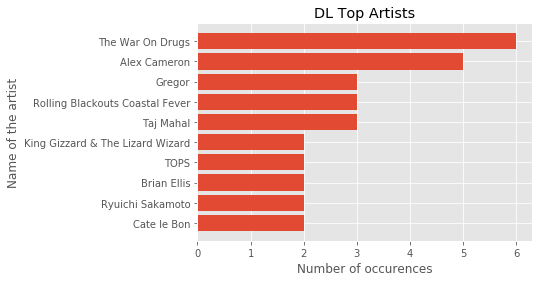

DL in stats:
	Popularity score is : 31.36
	Danceability score is : 0.62
	Energy score is : 0.65
	Loudness score is : -8.57
	Speechiness score is : 0.05
	Acousticness score is : 0.24
	Instrumentalness score is : 0.20
	Liveness score is : 0.16
	Tempo score is : 119.13
	Valence score is : 0.65


In [33]:
#Extract data and display summary
MM,MM_dataframe = single_user_dataframe('DL')
user_summary(MM,MM_dataframe)

In [34]:
#Compute the mean and median of the quantitative variables of the dataframe.
mean_features_all_users = songs.groupby(['Playlist Origin']).mean().reset_index()
med_features_all_users = songs.groupby(['Playlist Origin']).median().reset_index()

#Sort the users based on the median of a given criteria.
parameter_tosort = 'Danceability'
sorted_by_med = med_features_all_users.sort_values(by=[parameter_tosort],ascending=False).reset_index()
print('Top 3 users using the parameter %s are:' %(parameter_tosort))
print(sorted_by_med.loc[0:2,['Playlist Origin']])

Top 3 users using the parameter Danceability are:
  Playlist Origin
0    EH_Top100_18
1   JMG_Top100_18
2    LB_Top100_18


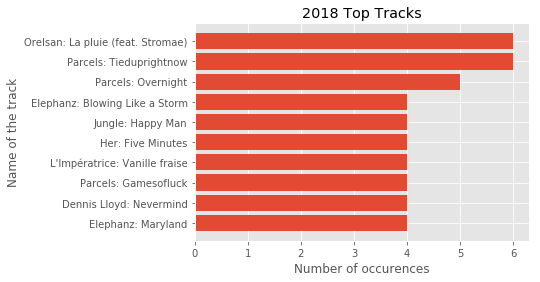

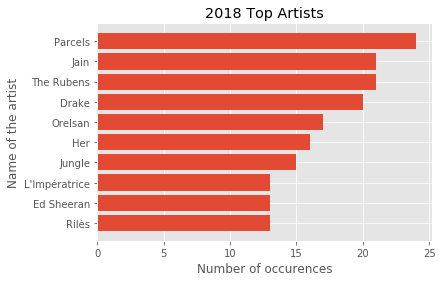

In [35]:
#Visualization of the top tracks and related artists for the whole dataframe
top_tracks = compute_top_tracks(songs)
top_artists = compute_top_artists(songs)

plot_tops(top_tracks,10,'2018 Top Tracks','Name of the track')
plot_tops(top_artists,10,'2018 Top Artists','Name of the artist')

## Song adjacency matrix construction

Pondering the different features

In [36]:
# Timestamp (0), Popularity (1), Danceability (2), Energy (3), Key (4), Loudness (5), Mode (6), Speechiness (7)
# Acousticness (8), Instrumentalness (9), Liveness (10), Valence (11), Tempo (12)

# Define relative importance of the features before defining a metric between any pair of them...
ponderation = np.ones((np_features.shape[1]))
ponderation[2] = 3
ponderation[4] = 0
ponderation[8] = 2
ponderation[9] = 2
ponderation[10] = 2

# Apply ponderation to features (weights will broadcast to all lines of the features array)
np_features_pondered = np_features*ponderation

> **NOTE**: At this point all parameters are a bit arbitrary

Building an adjacency matrix based of cosine similarity of tracks

In [37]:
# Calculating the distance between all pairs of songs and building the adjacency matrix
from scipy.spatial.distance import pdist, squareform
adjacency = squareform(pdist(np_features_pondered,metric='cosine'))

# Putting some order to the chaos
# Strong links between similar songs, weak links otherwise and all links between 0 and 1
adjacency = 1.5*(1-adjacency);
# Remove negative links
adjacency[adjacency < 0] = 0.0
# Bound all links to 1.0
adjacency[adjacency > 1.0] = 1.0
# Remove self links
np.fill_diagonal(adjacency, 0.0)

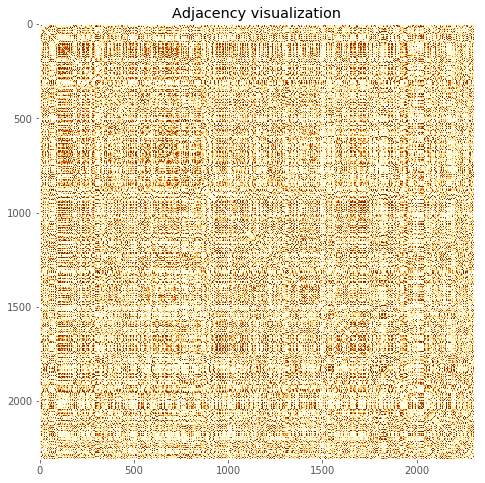

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Adjacency visualization')
im = ax.imshow(adjacency, cmap='YlOrBr')

> **NOTE**: Maybe what could be great would be to use the same concepts as in Milestone 3 (we have the work of the best group on github), on that dataset, spatial embedding and so on?

In [39]:
max_link_no = adjacency.shape[0]*adjacency.shape[1]

A bit of statistics...

In [40]:
print('Links with non-zero weight : %d per cent' % int(100*np.count_nonzero(adjacency!=0)/max_link_no))
print('Links with weight one : %d per cent' % int(100*np.count_nonzero(adjacency==1)/max_link_no))
print('Mean of non-zero links : %.3f' % np.mean(adjacency!=0))
print('Standard deviation of non-zero links : %.3f' % np.std(adjacency!=0))

Links with non-zero weight : 49 per cent
Links with weight one : 5 per cent
Mean of non-zero links : 0.492
Standard deviation of non-zero links : 0.500


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
    
</font>
</div>

***
***

# Part II: The Social Network

`TO DO`: 
- Get more info about the algorithms (betweeness / communities)
- Add content and interpretations
- Add some other "Key words" and concepts seen in the course
- _True_ Friendship graph

## Make it last forever, friendship never ends

Now, we want to construct a network based on real friendship relations. To do so, an adjacency matrix $A$ was constructed offline and imported on the notebook. It contains information about the relationship between the Spotify users. It is a binary matrix that can be read as follow:

- If the users $i$ and $j$ known each other more that meeting only one time, $A(i,j)$ is equal to one
- If they don't, $A(i,j)$ is equal to zero

In [41]:
# Import of the user_adjacency_file and processing to make it symmetric. (Only one diagonal was filled by hand)
adjacency_df = pd.read_csv('user_adjacency.csv', sep=',').fillna(0)
adjacency_df = adjacency_df.set_index('Unnamed: 0')
adjacency_df.index.names = ['Users']
adjacency_complete = adjacency_df + adjacency_df.T
np.fill_diagonal(adjacency_complete.values, 0) #no self loop

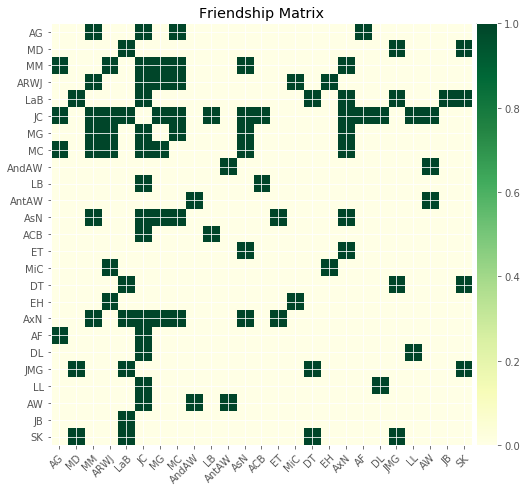

In [42]:
## FRIENDSHIP MATRIX DISPLAY ##
# According to the given color bar, the higher the score the closer the two playlists.
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(adjacency_complete, cmap='YlGn')

# Each tick corresponds to the corresponding user.
ax.set_xticks(np.arange(adjacency_complete.shape[1]))
ax.set_yticks(np.arange(adjacency_complete.shape[0]))
ax.set_xticklabels(adjacency_complete.columns)
ax.set_yticklabels(adjacency_complete.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
divider = make_axes_locatable(ax)
plt.title("Friendship Matrix")
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

Above is the matrix visulatization of the friendship relations. When the square is brown, it means that the two users are related and no otherwise.

In [43]:
## GRAPH CONSTRUCTION ##
to_graph_from = adjacency_complete #the adjacency to generate the graph from.

# From the adjacency generated by the users/artists graphs
F = nx.from_pandas_adjacency(to_graph_from)
F.name = 'Friends Graph'
print(nx.info(F))

Name: Friends Graph
Type: Graph
Number of nodes: 25
Number of edges: 51
Average degree:   4.0800


Among the 23 friends, the average degree is 4.08, meaning that each one of the user is related to an average 4 other people. But this number is not representative of the true distribution since some nodes have way higher degrees or the opposite as seen in the matrix visualtization

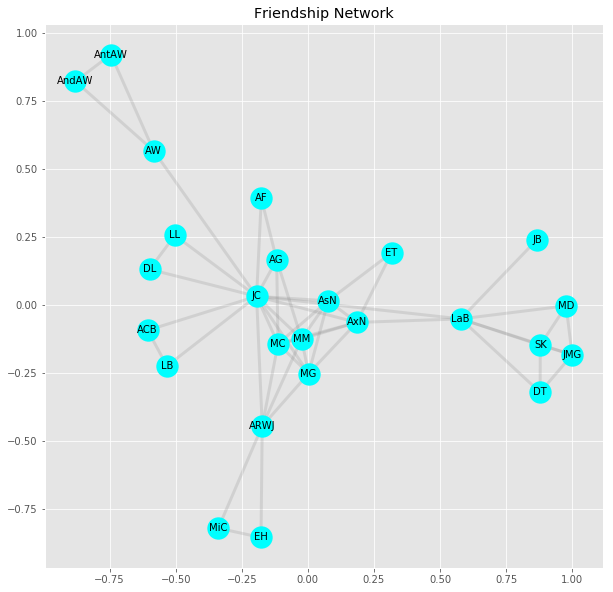

In [44]:
## GRAPH VISUALIZATION ##
#Some global parameters to pass in attributes.
options = {
    'node_color': 'cyan',
    'node_size': 500,
    'line_color': 'black',
    'linewidths': 0,
    'width': 3
}

#Display the graph with desired layout and labels
plt.figure(figsize = (10, 10))
pos=nx.spring_layout(F) # positions for all nodes
nx.draw_networkx_nodes(F,pos,cmap=plt.cm.jet,**options)# nodes
nx.draw_networkx_edges(F,pos,alpha=0.2,edge_color='grey',**options)# edges
nx.draw_networkx_labels(F,pos,font_size=10,font_family='sans-serif',font_color='k',**options)# labels
plt.title('Friendship Network')
plt.show()

Here is a visual inspection of the friendship network. We can distinguish a center cluster that is surrounded by smaller groups often connected to the main one by one simple user. This reflects the data collection process that was made mostly through the "bouche à oreille" and people that wanted to know more about their inter-relations

In [45]:
# Calculation of the betweenness centrality of the User Graph
betweenness = nx.betweenness_centrality(F)

# Assign each to an attribute in the User Graph
nx.set_node_attributes(F, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

#And the top 5 higher betweeness users are: 
for user, bw in sorted_betweenness[:5]:
    print(user,'has betweeness: %.3f' %bw)

JC has betweeness: 0.687
LaB has betweeness: 0.360
ARWJ has betweeness: 0.159
AW has betweeness: 0.159
AxN has betweeness: 0.094


Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v:

$$c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$$

where $V$ is the set of nodes, $\sigma(s, t)$ is the number of shortest $(s, t)-paths$, and $\sigma(s, t|v)$ is the number of those paths passing through some node v other than s, t. If s = t, $\sigma(s, t) = 1$, and if $v \in {s, t}$, $\sigma(s, t|v) = 0$. More in the [Networkx reference page](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html)

We used that to distinguish the cohesive users, meaning the ones that you should go to if you want to meet the people of the network that you do not know.

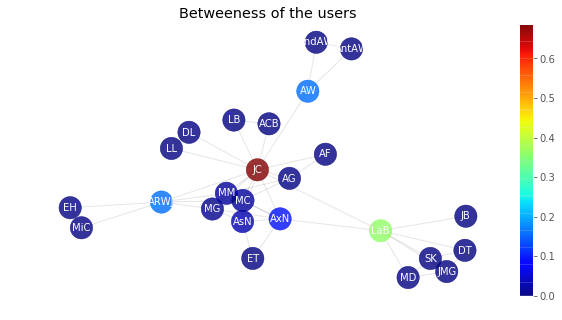

In [46]:
#Display the above resutls directly on the graph
list_nodes =list(F.nodes())
list_nodes.reverse()

plt.figure(figsize = (10, 5))
pos = nx.spring_layout(F)
ec = nx.draw_networkx_edges(F, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(F, pos, nodelist=list_nodes, node_color=[F.nodes[n]["betweenness"] for n in list_nodes],with_labels=True, alpha=0.8, node_shape = '.',node_size = 2000, cmap=plt.cm.jet)
lc = nx.draw_networkx_labels(F,pos,font_size=10,font_family='sans-serif',font_color='w')# labels
plt.colorbar(nc)
plt.title('Betweeness of the users')
plt.axis('off')
plt.show()

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br>The color gradient represents the betweeness of a given node. In that graph, the result is not surprising as JC was the one to originaly ask friends for data. LaB has also an high score because of the very same reason. The other bluer nodes are basically end nodes, when the data collection chain stopped.
</font>
</div>

# Part III: The Musical Network

We now want to see how well the real friendship network correlates with the one generated through musical affinities between users. For that, we will need to construct some basic networks to build our further analysis on. 

In [47]:
## NODE DATAFRAME CONSTRUCTION ##
#Extract proper column from playlists and add node caracteristics
playlists = pd.DataFrame(songs['Playlist Origin'].unique())
playlists['Type'] = 'Playlist'
playlists['Color'] = 'orange'

#Extract proper column from artists and add node caracteristics
artists = pd.DataFrame(songs['Artist'].unique())
artists['Type'] = 'Artists'
artists['Color'] = 'black'

#Extract proper column from tracks and add node caracteristics
tracks = pd.DataFrame(songs['Track Name'].unique())
#Add some caracteristics
tracks['Type'] = 'Titles'
tracks['Color'] = 'grey'

In [48]:
#Merge the users (playlists), artists and tracks into one single dataframe
nodes = playlists.append(artists).append(tracks).drop_duplicates(keep='first').reset_index(drop=True)
nodes.columns=['Name','Type','Color']
nodes.set_index('Name', inplace=True)

In [49]:
def graph_visualizer(Graph,title):
    #Some global parameters to pass in attributes.
    options = {
        'node_color': [Graph.node[n]['Color'] for n in Graph.nodes()],
        'node_size': 50,
        'line_color': 'grey',
        'linewidths': 0,
        'width': 0.1,
    }
    #Display the graph with desired layout.
    fig = plt.figure(figsize = (15, 15))
    nx.draw(Graph, pos=nx.spring_layout(Graph),**options)
    plt.title(title)
    plt.show()

### User / Artists graph

In [50]:
## GRAPH CONSTRUCTION ##
G=nx.from_pandas_edgelist(songs, 'Playlist Origin', 'Artist',edge_attr=None, create_using= nx.Graph())
G.name = 'User/Artists Graph'
#print(nx.info(G))

#Set node attributes from nodes dataframe
nx.set_node_attributes(G, nodes['Type'].to_dict(), 'Type')
nx.set_node_attributes(G, nodes['Color'].to_dict(), 'Color')

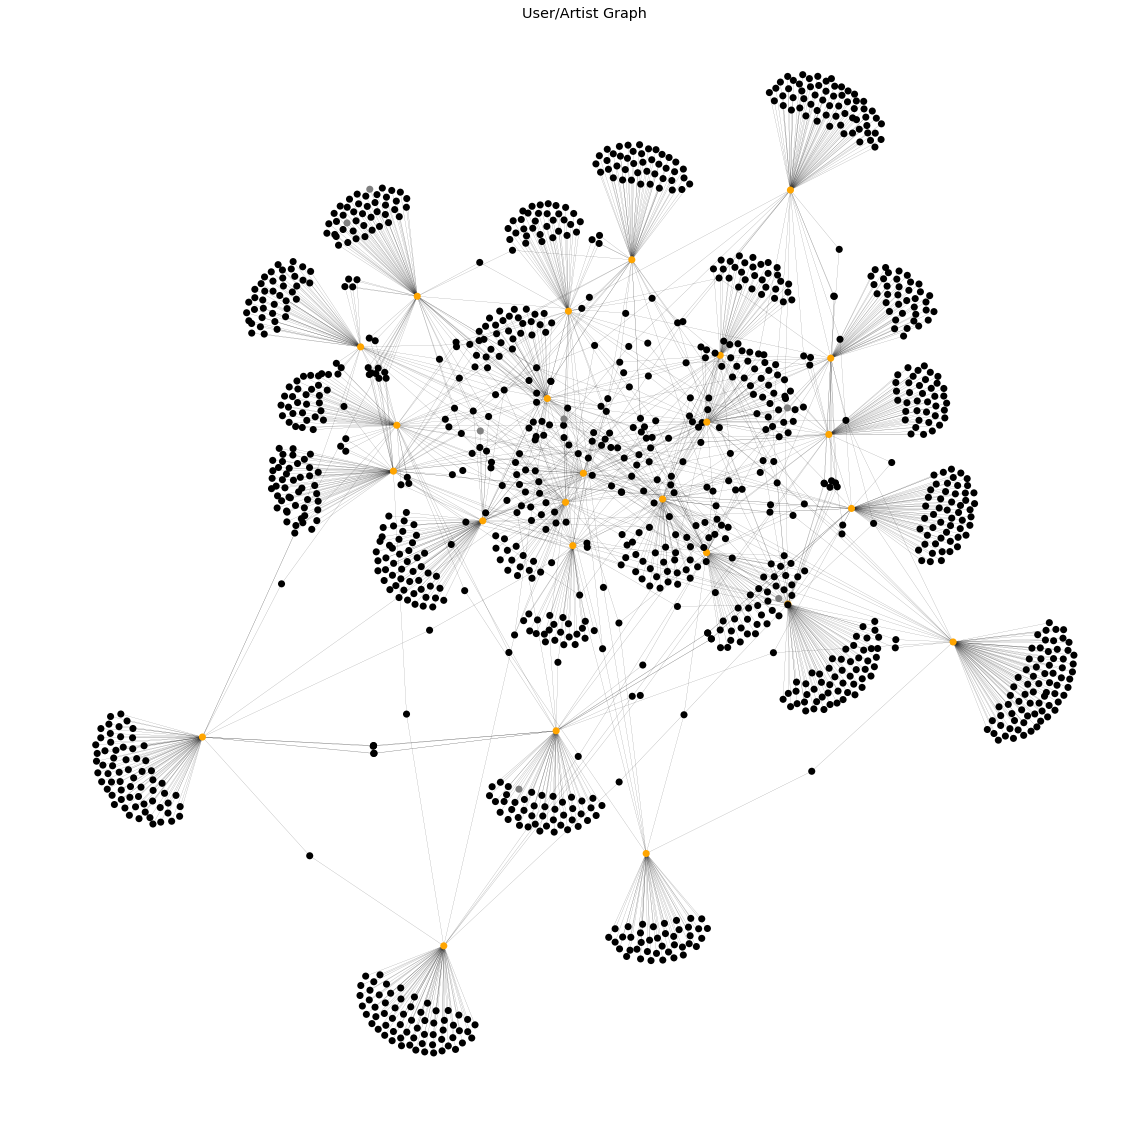

In [51]:
## GRAPH VISUALIZATION ##
graph_visualizer(G,'User/Artist Graph')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br>Here, the orange nodes are the users, and the black one represent the different artists. We can observe that the vast majority of the artists are present in a single playlist linked to a single user. There is nevertheless some artists that are shared by two or more users. This first insight will be developped later, let see the Artist/Track distribution
</font>
</div>

> Add numbers?

### Artist / Track Graph

In [52]:
## GRAPH CONSTRUCTION ##
G4=nx.from_pandas_edgelist(songs,'Artist','Track Name')
G4.name = 'Artists/Tracks Graph'
nx.set_node_attributes(G4, nodes['Type'].to_dict(), 'Type')
nx.set_node_attributes(G4,nodes['Color'].to_dict(), 'Color')
#print(nx.info(G4))

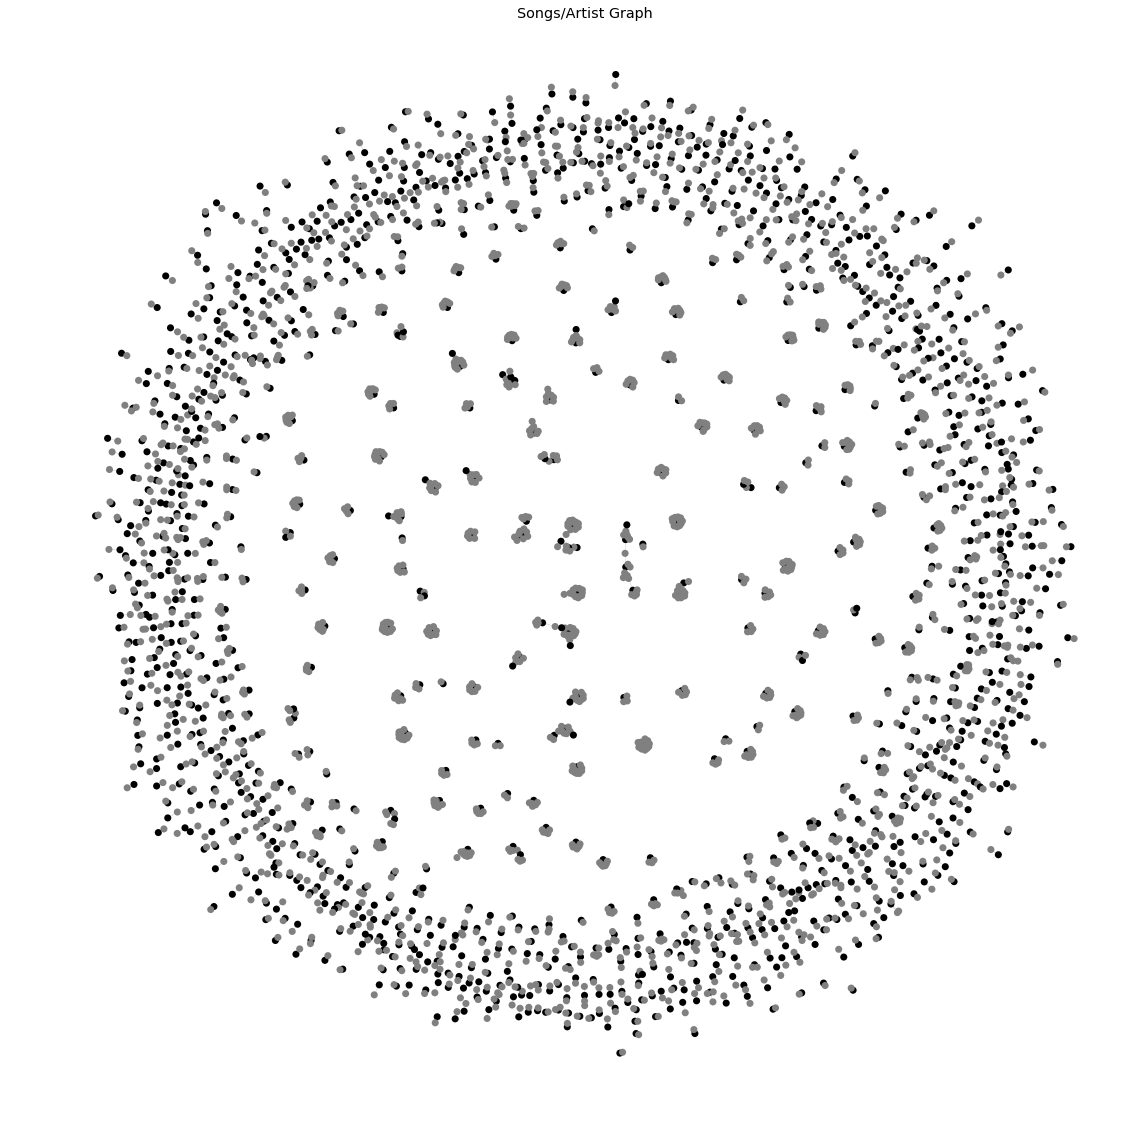

In [53]:
## GRAPH VISUALIZATION ##
graph_visualizer(G4,'Songs/Artist Graph')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br>Here, we can observe that the mast majority of the artists are contained only one time in the Spotify Data base. Some are present more than that, as we have previously observed in the dataset descriptive analysis. Now, let's put everything together.
</font>
</div>

### User / Artists / Tracks Graph

In [54]:
## EDGE DATAFRAME CONSTRUCTION ##
#*The edge dataframe to be passed on the graph constructor
# The links between users and artists
playlist_artists = songs[['Playlist Origin','Artist']]
playlist_artists.columns=['Start','End']

# The links between artists and tracks
artists_tracks = songs[['Artist','Track Name']]
artists_tracks.columns=['Start','End']

#Merge everything into a single dataframe
edges_full = playlist_artists.append(artists_tracks).drop_duplicates(keep='first').reset_index(drop=True)

In [55]:
## GRAPH CONSTRUCTION ##
G2=nx.from_pandas_edgelist(edges_full,'Start','End')
G2.name = 'User/Artists/Tracks Graph'
print(nx.info(G2))

#Adding some node attributes to ease the visualization.
nx.set_node_attributes(G2, nodes['Type'].to_dict(), 'Type')
nx.set_node_attributes(G2, nodes['Color'].to_dict(), 'Color')

Name: User/Artists/Tracks Graph
Type: Graph
Number of nodes: 3499
Number of edges: 3926
Average degree:   2.2441


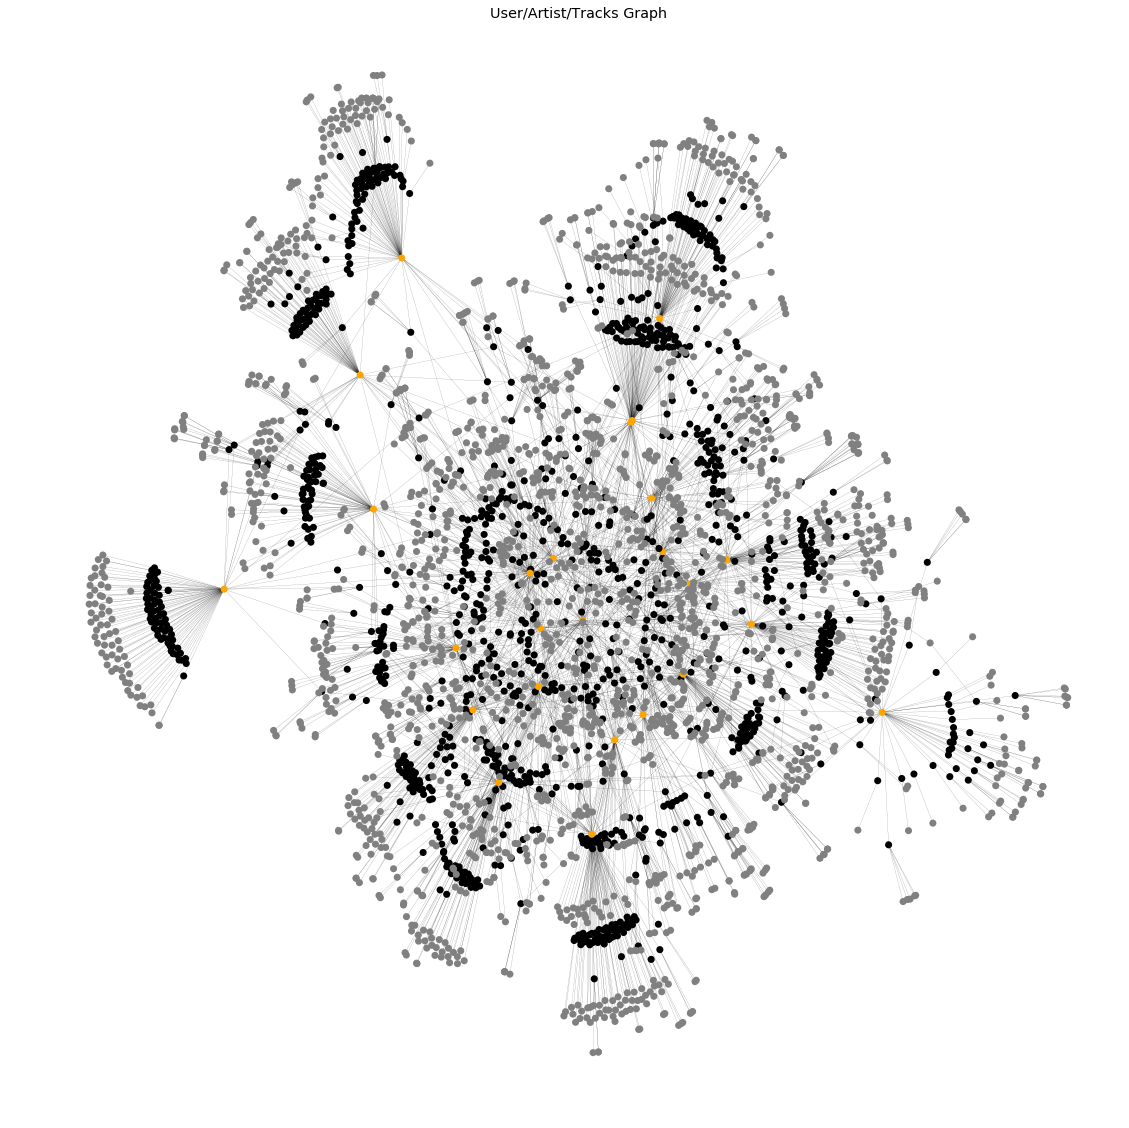

In [56]:
## GRAPH VISUALIZATION ##
graph_visualizer(G2,'User/Artist/Tracks Graph')

In [57]:
#Export the graph intp a .gexf file to visualize it under Giphy or something like it.
nx.write_gexf(G2,'User_Artist_Tracks.gexf')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br> Here is a complete visualization of the dataset, where the users (orange) are linked to to artists (black) linked to songs (grey). This visualization put in front the fact that one tends to listen to more one track per given artist. Is there fans in here?
</font>
</div>

## Who are the closest friends ?

Based on the User/Artist graph, we will assess the musical affinities between users. It will be done by conting the number of shortest paths of lenght two between users, meaning the presence of the same artist in the two playlists. In the case where shortest path of lenght two does not exist between users, no link is reported. 

### The similarities dataframe

In [58]:
#Extract the playlist name from the song dataframe
playlists_list = songs['Playlist Origin'].unique()
#Keep only the user initials for further analysis
users = [playlists_list[i][:-10] for i in range(0,len(playlists_list))]

In [59]:
## SIMILARITIES CALCULATIONS ##
# Initialization of the differents parameters to assess
current = 0 #current user number to analyse.
shortest_paths = np.zeros(shape=(len(playlists),len(playlists))) #Length of the shortest paths between users.
similarities = np.zeros(shape=(len(playlists),len(playlists))) #Number of direct shortest paths betweenn users.

for i in range(0,len(playlists_list)):
    for k in range(0,len(playlists_list)):
        if playlists_list[k] != playlists_list[i]:
            shortest_path = nx.shortest_path_length(G, source=playlists_list[i], target=playlists_list[k])
            #print('Link between %s and %s is %d' % (playlists[i],playlists[k],shortest_path))
            shortest_paths[i,k] = shortest_path
            if shortest_path == 2:
                similarities[i,k] = sum(1 for _ in nx.all_shortest_paths(G, source=playlists_list[i], target=playlists_list[k]))
    current = i+1

In [60]:
#Transform the similarities array into dataframe for readability.
similarities_df = pd.DataFrame(similarities)
#Associate each row and columns with their users.
similarities_df.columns=users
similarities_df.index=users

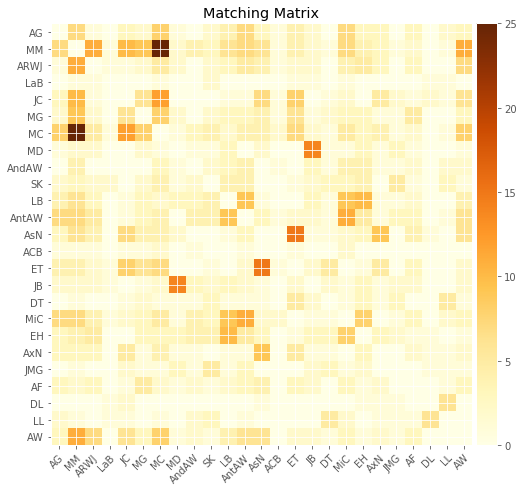

In [61]:
## SIMILARITIES DISPLAY ##
# According to the givene color bar, the higher the score the closer the two playlists.
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(similarities_df, cmap='YlOrBr')

# Each tick corresponds to the corresponding user.
ax.set_xticks(np.arange(similarities_df.shape[1]))
ax.set_yticks(np.arange(similarities_df.shape[0]))
ax.set_xticklabels(similarities_df.columns)
ax.set_yticklabels(similarities_df.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
divider = make_axes_locatable(ax)
plt.title("Matching Matrix")
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br> The above visualization present the number of "matches" between users. The more red the color, the more two users are linked. For exemple MC and MM are really strongly linked with around 25 artists shared. On the opposite, DL is not really related to the majority of the people with more that with one or two artists.
</font>
</div>

### The Users Graph 

Now that we have a proper adjacency matrix, we can generate a weighted graph based on it. The stronger the link between two users, the stronger the weight of the edge will be. Let's take a look

In [62]:
# Filtering option if we want the low connectivities no to be taken into account.
threshold = 2
similarities_df_filtered=similarities_df[similarities_df>=threshold]
similarities_df_filtered = similarities_df_filtered.fillna(0)

In [63]:
## GRAPH CONSTRUCTION ##
to_graph_from = similarities_df #the adjacency to generate the graph from.

# From the adjacency generated by the users/artists graphs
G3 = nx.from_pandas_adjacency(to_graph_from)
G3.name = 'Users Graph'
print(nx.info(G3))

Name: Users Graph
Type: Graph
Number of nodes: 25
Number of edges: 221
Average degree:  17.6800


We can observe that the average degree is already higher in that graph. This is probably due to the fact that 100 songs is a number high enough to be somehow related to a single or more song in another playlist.

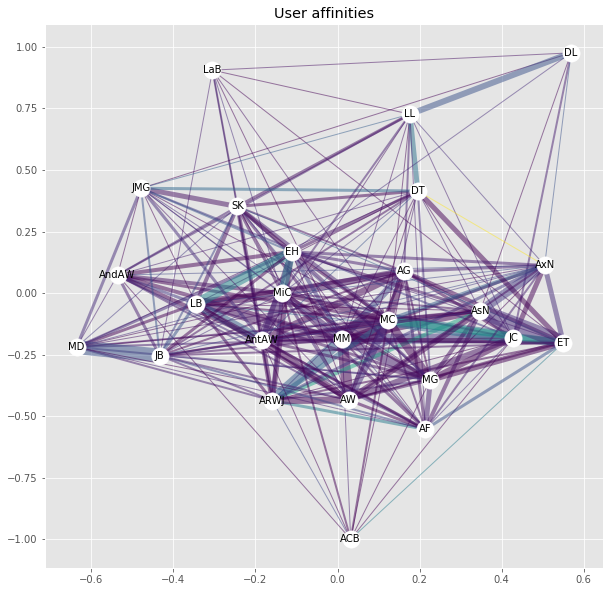

In [64]:
## GRAPH VISUALIZATION ##
#Some global parameters to pass in attributes.
options = {
    'node_color': 'white',
    'node_size': 500,
    'width': [d['weight'] for (u, v, d) in G3.edges(data=True) if d['weight'] > 0]
}

#Display the graph with desired layout and labels
list_edges =list(G3.edges())
list_edges.reverse()

plt.figure(figsize = (10, 10))
pos=nx.spring_layout(G3) # positions for all nodes
nx.draw_networkx_nodes(G3,pos,node_color='white')# nodes
nx.draw_networkx_labels(G3,pos,font_size=10,font_family='sans-serif',font_color='k')# labels
nx.draw_networkx_edges(G3,pos,nodelist=list_edges,alpha=0.5,edge_color=[G3.edges[n]['weight'] for n in list_edges],cmap=plt.cm.jet,**options)# edges
plt.title('User affinities')
plt.show()

In [65]:
## DEGREE CALCULATIONS ##
# Exctraction of the degrees of each users from the User Graphs
degrees = dict(G3.degree(G3.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

#And the top 5 most linked users  are.. 
for user, degree in sorted_degree[:]:
    print(user,'is linked to', degree, 'people')

MM is linked to 23 people
MC is linked to 23 people
AntAW is linked to 21 people
MiC is linked to 21 people
MG is linked to 20 people
JB is linked to 20 people
EH is linked to 20 people
AW is linked to 20 people
AG is linked to 19 people
ARWJ is linked to 19 people
SK is linked to 19 people
LB is linked to 19 people
AxN is linked to 19 people
AF is linked to 19 people
JC is linked to 18 people
AsN is linked to 18 people
DT is linked to 18 people
MD is linked to 17 people
ET is linked to 17 people
AndAW is linked to 16 people
JMG is linked to 16 people
LL is linked to 14 people
ACB is linked to 10 people
LaB is linked to 9 people
DL is linked to 7 people


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br> Due to the network structure and the corresponding higher degree, there is visualy an abondance of edges. But the number of links between people can vary greatly from simple (DL or LaB) to triple (MM or MC). This may be explained by the presence of several confidential artists with respect to the trend and popularity numbers in the playlist of certain users. In the graph above, the thicker the line, the higher the degree
</font>
</div>

### Betweeness centrality

`TO DO: Get more info about the algorithms and what does it mean`

In [66]:
# Calculation of the betweenness centrality of the User Graph
betweenness = nx.betweenness_centrality(G3)

# Assign each to an attribute in the User Graph
nx.set_node_attributes(G3, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

#And the top 5 higher betweeness users are: 
for user, bw in sorted_betweenness[:5]:
    print(user,'has betweeness: %.3f' %bw)

MM has betweeness: 0.023
MC has betweeness: 0.023
JC has betweeness: 0.020
MiC has betweeness: 0.019
EH has betweeness: 0.017


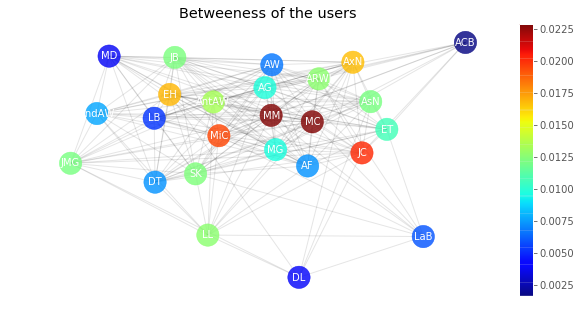

In [67]:
#Display the above resutls directly on the graph
list_nodes =list(G3.nodes())
list_nodes.reverse()
plt.figure(figsize = (10, 5))
pos = nx.spring_layout(G3)
ec = nx.draw_networkx_edges(G3, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G3, pos, nodelist=list_nodes, node_color=[G3.nodes[n]["betweenness"] for n in list_nodes],with_labels=True, alpha=0.8, node_shape = '.',node_size = 2000, cmap=plt.cm.jet)
lc = nx.draw_networkx_labels(G3,pos,font_size=10,font_family='sans-serif',font_color='w')# labels
plt.colorbar(nc)
plt.title('Betweeness of the users')
plt.axis('off')
plt.show()

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
    CONTENT
</font>
</div>

### Users communities

Now we want to do a community analysis, or clustering on the graph. To do so, we use the Louvain method which is based on the optimisation as the algorithm progresses of a quantity called modularity. Modularity is defined as a value between -1 and 1 that measures the density of links inside communities compared to links between communities. For a weighted graph, modularity is defined as:

${\displaystyle Q={\frac {1}{2m}}\sum \limits _{ij}{\bigg [}A_{ij}-{\frac {k_{i}k_{j}}{2m}}{\bigg ]}\delta (c_{i},c_{j})}$

where

- $A_{ij}$ represents the edge weight between nodes $i$ and $j$

- $k_{i}$ and $k_j$ are the sum of the weights of the edges attached to nodes {\displaystyle i} $i$ and $j$, respectively

- $2m$ is the sum of all of the edge weights in the graph

- $c_{i}$ and $c_{j}$ are the communities of the nodes

- $\delta$  is a simple delta function.

[Source](https://en.wikipedia.org/wiki/Louvain_Modularity)

In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and for each community it is tested whether by joining it to a neighboring community, we can obtain a better clustering. The processus is repeated until no more advancement are made. We will use this tool to decect possible communities starting from our Network

In [68]:
from community import community_louvain

In [69]:
#Partition the data into communities from the User Graph
partition = community_louvain.best_partition(G3)
# add it as an attribute to the nodes
for n in G3.nodes:
    G3.nodes[n]["louvain"] = partition[n]

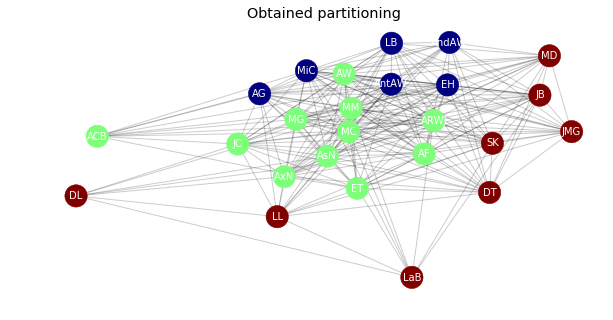

In [70]:
#Visualize the partitioning
plt.figure(figsize = (10, 5))
pos = nx.spring_layout(G3,k=0.2)
ec = nx.draw_networkx_edges(G3, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G3, pos, nodelist=G3.nodes(), node_color=[G3.nodes[n]["louvain"] for n in G3.nodes], with_labels=False, node_size=500, cmap=plt.cm.jet)
lc = nx.draw_networkx_labels(G3,pos,font_size=10,font_family='sans-serif',font_color='w',**options)# labels
plt.title('Obtained partitioning')
plt.axis('off')
plt.show()

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Interpretation</b>
</font>
<font color='black'>
<br> From the figure above, we can see that there is three major groups obtained. Knowing the different relationship between users, one can remark that the blue cluster is composed mainly of non-EPFL users, with few links with the main connected friends from the real friendship adjacency. The green cluster contains the _core_ group of student, that are apart some exceptions, close friends. The third cluster is composed of foreign students or friends that live or come from far away from Switzerland. Differences in music culture, ages or simply the fact that these users have only few relation with the major part of the dataset can explain why they are appart in one cluster. It is really interesting to see that without knowing anything about real-life relations, music tastes can lead to cluster of this kind, that are somewhat close to what we get in reality. 
</font>
</div>

<div class="alert alert-block alert-info"><b>End :</b><br />
<br />
<br />
</div>